In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "AppleGothic"
from IPython.display import Image
plt.rc('font', family="AppleGothic")

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.stats.multicomp import MultiComparison

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy import stats
import scipy 
from pycaret.regression import *
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas_profiling
import statsmodels.api as sm
from sklearn.decomposition import PCA
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [4]:
grid_250 = pd.read_csv('/Users/Desktop/DataCampus/data/real_data/250grid_all.csv')

In [5]:
grid_250 = grid_250.fillna(0)

In [6]:
grid_250['성폭력취약인구'] = grid_250['고등여성인구']+grid_250['20대여성인구']
grid_250['건축물(30_)'] = grid_250['건축물(30_34)']+grid_250['건축물(35)']
grid_250['GRADE_전체'] = grid_250['GRADE_전체'].apply(lambda x: x-1 if x>0 else x)
grid_250 = grid_250.drop(columns = ['20대여성인구','고등여성인구','INDEX'])

### 행정동별로 평균 범죄주의구간 등급 확인

In [7]:
list(grid_250['행정동코드'].unique())

['조촌동',
 '여의동',
 '삼천3동',
 '혁신동',
 '효자4동',
 '효자5동',
 '팔복동',
 '송천2동',
 '평화2동',
 '서신동',
 '덕진동',
 '효자3동',
 '효자2동',
 '중화산2동',
 '삼천2동',
 '삼천1동',
 '송천1동',
 '효자1동',
 '중화산1동',
 '진북동',
 '금암1동',
 '호성동',
 '완산동',
 '중앙동',
 '평화1동',
 '금암2동',
 '서서학동',
 '노송동',
 '인후2동',
 '풍남동',
 '동서학동',
 '인후1동',
 '우아1동',
 '인후3동',
 '우아2동']

In [8]:
feat_N = grid_250[(grid_250['총인구']==0)&(grid_250['건축물(30_34)']==0)&(grid_250['건축물(35)']==0)&(grid_250['가로등']==0)&(grid_250['공영주차장']==0)&(grid_250['공중화장실']==0)&(grid_250['숙박업소']==0)
        &(grid_250['대규모점포']==0)&(grid_250['대부업현황']==0)&(grid_250['상가']==0)&(grid_250['어린이보호']==0)&(grid_250['원룸_오피스텔']==0)&(grid_250['cctv']==0)&(grid_250['신호등']==0)&(grid_250['횡단보도']==0)
        &(grid_250['버스정류장']==0)&(grid_250['개별주택가격']==0)] #target 제외 모든 변수가 0인 row
feat_Y = grid_250[(grid_250['총인구']>0)|(grid_250['건축물(30_34)']>0)|(grid_250['건축물(35)']>0)|(grid_250['가로등']>0)|(grid_250['공영주차장']>0)|(grid_250['공중화장실']>0)|(grid_250['숙박업소']>0)
        |(grid_250['대규모점포']>0)|(grid_250['대부업현황']>0)|(grid_250['상가']>0)|(grid_250['어린이보호']>0)|(grid_250['원룸_오피스텔']>0)|(grid_250['cctv']>0)|(grid_250['신호등']>0)|(grid_250['횡단보도']>0)
        |(grid_250['버스정류장']>0)|(grid_250['개별주택가격']>0)] #target 제외 모든 변수가 0보다 큰 row

In [9]:
print(len(feat_N),len(feat_Y))

1460 2038


- 모든 피쳐가 0인 행이 `1460`개이고, 한 피쳐라도 0보다 큰 행은 `2038`개 (공시지가와 타겟 제외)

- 폭력등급이 0보다 큰 로우는 900개, 절도 등급이 0보다 큰 로우는 836개, 성폭력 등급이 0보다 큰 로우는 303개가 있다. 
- 모든 피쳐가 0임에도 불구하고(1460개의 피쳐), 폭력등급이 있는 로우는 19개, 절도 13개, 성폭력 4개가 있었다.

In [10]:
new_grid = feat_Y

In [11]:
new_grid['자율방범대'].sum()

48

In [12]:
len(new_grid)

2038

In [13]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_전체', '행정동면적',
       '성폭력취약인구', '건축물(30_)'],
      dtype='object')

In [14]:
numerical_feats = new_grid.dtypes[new_grid.dtypes != "object"].index.tolist()
numerical_feats.remove('GRADE_전체')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = new_grid.dtypes[new_grid.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  32
Number of Categorical features:  2


In [15]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_전체']).columns)
feature = new_grid[feature_list]
target = new_grid[['GRADE_전체']]

In [16]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_전체', '행정동면적',
       '성폭력취약인구', '건축물(30_)'],
      dtype='object')

In [17]:
new_grid['범죄발생'] = 0

In [18]:
new_grid.loc[(new_grid['GRADE_전체']==0),'범죄발생'] = 0
new_grid.loc[(new_grid['GRADE_전체']>0),'범죄발생'] = 1

In [19]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_전체','범죄발생']).columns)
feature = new_grid[feature_list]
target = new_grid[['범죄발생']]

In [20]:
group_1 = new_grid.loc[(new_grid['범죄발생']==0)]
group_2 = new_grid.loc[(new_grid['범죄발생']==1)]

### 변수 제거를 위한 분산분석

In [21]:
def anova(x):
    F_statistic, pVal = stats.f_oneway(group_1[x], group_2[x])

    print(x,' 데이터의 일원분산분석 결과 : F={0:.1f}, p={1:.5f}'.format(F_statistic, pVal))
    if pVal < 0.05:
        print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

In [22]:
anova('총인구')
anova('유소년인구')
anova('고령인구')
anova('성폭력취약인구')
anova('건축물(30_34)')
anova('건축물(35)')
anova('건축물(30_)')
anova('개별주택가격')
anova('공시지가')
anova('가로등')
anova('보안등')
anova('공중화장실')
anova('버스정류장')
anova('공영주차장')
anova('교육시설')
anova('대규모점포')
anova('대부업현황')
anova('룸살롱')
anova('버스정류장')
anova('보안등')
anova('상가')
anova('숙박업소')
anova('술집')
anova('어린이보호')
anova('어린이집')
anova('오락시설')
anova('원룸_오피스텔')
anova('음식점')
anova('자율방범대')
anova('파출소')
anova('cctv')
anova('신호등')
anova('횡단보도')

총인구  데이터의 일원분산분석 결과 : F=538.1, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
유소년인구  데이터의 일원분산분석 결과 : F=232.7, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
고령인구  데이터의 일원분산분석 결과 : F=585.0, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
성폭력취약인구  데이터의 일원분산분석 결과 : F=507.7, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
건축물(30_34)  데이터의 일원분산분석 결과 : F=126.4, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
건축물(35)  데이터의 일원분산분석 결과 : F=235.4, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
건축물(30_)  데이터의 일원분산분석 결과 : F=283.2, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
개별주택가격  데이터의 일원분산분석 결과 : F=114.2, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
공시지가  데이터의 일원분산분석 결과 : F=657.0, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
가로등  데이터의 일원분산분석 결과 : F=470.4, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
보안등  데이터의 일원분산분석 결과 : F=216.4, p=0.00000
P-value 값이 충

### 변수 선택을 위한 사후검정 실시

In [23]:
def compare(x,y):
    comp = MultiComparison(new_grid[x], new_grid[y])
    result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
    return result[0]

In [24]:
compare('총인구','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-23.1965,0.0,0.0,True


In [25]:
compare('유소년인구','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-15.2539,0.0,0.0,True


In [26]:
compare('고령인구','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-24.1868,0.0,0.0,True


In [27]:
compare('성폭력취약인구','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-22.5325,0.0,0.0,True


In [28]:
compare('건축물(30_34)','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-11.2421,0.0,0.0,True


In [29]:
compare('건축물(35)','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-15.3429,0.0,0.0,True


In [30]:
compare('건축물(30_)','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-16.8299,0.0,0.0,True


In [31]:
compare('개별주택가격','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-10.6868,0.0,0.0,True


In [32]:
compare('공시지가','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-25.6313,0.0,0.0,True


In [33]:
compare('공영주차장','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-7.0214,0.0,0.0,True


In [34]:
compare('공중화장실','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-8.9335,0.0,0.0,True


In [35]:
compare('교육시설','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-15.3263,0.0,0.0,True


In [36]:
compare('대규모점포','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-5.5871,0.0,0.0,True


In [37]:
compare('대부업현황','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-7.5455,0.0,0.0,True


In [38]:
compare('룸살롱','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-4.3358,0.0,0.0,True


In [39]:
compare('버스정류장','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-15.4233,0.0,0.0,True


In [40]:
compare('보안등','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-14.7097,0.0,0.0,True


In [41]:
compare('상가','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-22.2769,0.0,0.0,True


In [42]:
compare('숙박업소','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-7.0141,0.0,0.0,True


In [43]:
compare('술집','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-12.298,0.0,0.0,True


In [44]:
compare('어린이보호','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-8.0476,0.0,0.0,True


In [45]:
compare('어린이집','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-12.8244,0.0,0.0,True


In [46]:
compare('오락시설','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-12.9788,0.0,0.0,True


In [47]:
compare('원룸_오피스텔','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-14.1653,0.0,0.0,True


In [48]:
compare('음식점','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-19.5446,0.0,0.0,True


In [49]:
compare('자율방범대','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-6.2176,0.0,0.0,True


In [50]:
compare('파출소','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-4.4154,0.0,0.0,True


In [51]:
compare('cctv','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-22.8425,0.0,0.0,True


In [52]:
compare('신호등','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-15.8808,0.0,0.0,True


In [53]:
compare('횡단보도','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-23.2146,0.0,0.0,True


In [54]:
compare('가로등','범죄발생')

group1,group2,stat,pval,pval_corr,reject
0,1,-21.6884,0.0,0.0,True


### 종속변수 범주를 잘 구분해줄 것이라 판단되는 피쳐 선택 

##### '총인구','건축물(35)','개별주택가격','공시지가','가로등','공영주차장','공중화장실','교육시설','룸살롱','버스정류장','상가','숙박업소','술집','오락시설','원룸_오피스텔','음식점' 'cctv','횡단보도'
#### target = '폭력빈도_4'

In [111]:
scaler = StandardScaler()
new_grid[numerical_feats] = scaler.fit_transform(new_grid[numerical_feats])

In [112]:
feature_list = list(new_grid.drop(columns = ['음식점','행정동코드','ID','GRADE_전체','행정동면적','범죄발생','총인구','유소년인구','성폭력취약인구','건축물(30_34)','건축물(35)','대규모점포','파출소','자율방범대']).columns)
feature = new_grid[feature_list]
target = new_grid[['범죄발생']]

In [113]:
x = sm.add_constant(feature, prepend = False)

mnlogit_mod = sm.MNLogit(target, x)
mnlogit_fit = mnlogit_mod.fit(method='bfgs')

print (mnlogit_fit.summary())

         Current function value: 0.368668
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                          MNLogit Regression Results                          
Dep. Variable:                   범죄발생   No. Observations:                 2038
Model:                        MNLogit   Df Residuals:                     2015
Method:                           MLE   Df Model:                           22
Date:                Mon, 23 Aug 2021   Pseudo R-squ.:                  0.4681
Time:                        16:20:54   Log-Likelihood:                -751.34
converged:                      False   LL-Null:                       -1412.6
Covariance Type:            nonrobust   LLR p-value:                2.905e-266
    범죄발생=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
고령인구           1.3888      0.274      5.069      0.000       0.852       1.9

In [114]:
len(new_grid.columns)

36

In [115]:
len(feature.columns)

22

In [116]:
feature_list

['고령인구',
 '개별주택가격',
 '공시지가',
 '가로등',
 '공영주차장',
 '공중화장실',
 '교육시설',
 '대부업현황',
 '룸살롱',
 '버스정류장',
 '보안등',
 '상가',
 '숙박업소',
 '술집',
 '어린이보호',
 '어린이집',
 '오락시설',
 '원룸_오피스텔',
 'cctv',
 '신호등',
 '횡단보도',
 '건축물(30_)']

In [117]:
model = LogisticRegression(random_state=0, solver ='lbfgs')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

accuracy = 0.8331697742885181


array([[951,  72],
       [268, 747]])

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature,target, test_size=0.25, stratify=target, random_state=123456)

In [119]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)

In [120]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123456,
                       verbose=0, warm_start=False)

In [121]:
from sklearn.metrics import accuracy_score

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.815
Mean accuracy score: 0.824


In [122]:
np.array(feature_list)

array(['고령인구', '개별주택가격', '공시지가', '가로등', '공영주차장', '공중화장실', '교육시설', '대부업현황',
       '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설',
       '원룸_오피스텔', 'cctv', '신호등', '횡단보도', '건축물(30_)'], dtype='<U8')

In [123]:
np.array(rf.feature_importances_)

array([1.43261758e-01, 7.91816020e-02, 1.78557771e-01, 5.10796699e-02,
       1.23126306e-03, 9.87730656e-03, 4.38716722e-02, 1.07913367e-03,
       3.99728568e-05, 1.06402338e-02, 4.13902188e-02, 1.72382216e-01,
       8.63862619e-04, 1.29630740e-02, 4.86578263e-03, 6.78764490e-03,
       2.03412578e-03, 4.91019007e-02, 2.37986048e-02, 3.02838865e-02,
       8.55505707e-02, 5.11577294e-02])

In [152]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')



plot_feature_importance(rf.feature_importances_,feature_list,'Randomforest')

ValueError: arrays must all be same length

In [125]:
from sklearn.metrics import classification_report
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
print(classification_report(target, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1023
           1       0.91      0.74      0.81      1015

    accuracy                           0.83      2038
   macro avg       0.85      0.83      0.83      2038
weighted avg       0.85      0.83      0.83      2038



In [126]:
from sklearn.model_selection import KFold

scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature = df_train[feature_list]
    target = df_train[['범죄발생']]
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(target,y_pred1)
    acc_2=accuracy_score(df_test['범죄발생'],y_pred2)
    
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.84133043, 검증 Accuracy = 0.82843137
학습 Accuracy = 0.83642312, 검증 Accuracy = 0.85294118
학습 Accuracy = 0.83751363, 검증 Accuracy = 0.81862745
학습 Accuracy = 0.83533261, 검증 Accuracy = 0.81862745
학습 Accuracy = 0.83751363, 검증 Accuracy = 0.81862745
학습 Accuracy = 0.83424209, 검증 Accuracy = 0.83333333
학습 Accuracy = 0.83642312, 검증 Accuracy = 0.82352941
학습 Accuracy = 0.83315158, 검증 Accuracy = 0.82352941
학습 Accuracy = 0.83378747, 검증 Accuracy = 0.82758621
학습 Accuracy = 0.83051771, 검증 Accuracy = 0.85221675
[0.82843137 0.85294118 0.81862745 0.81862745 0.81862745 0.83333333
 0.82352941 0.82352941 0.82758621 0.85221675]


0.8297450014488554

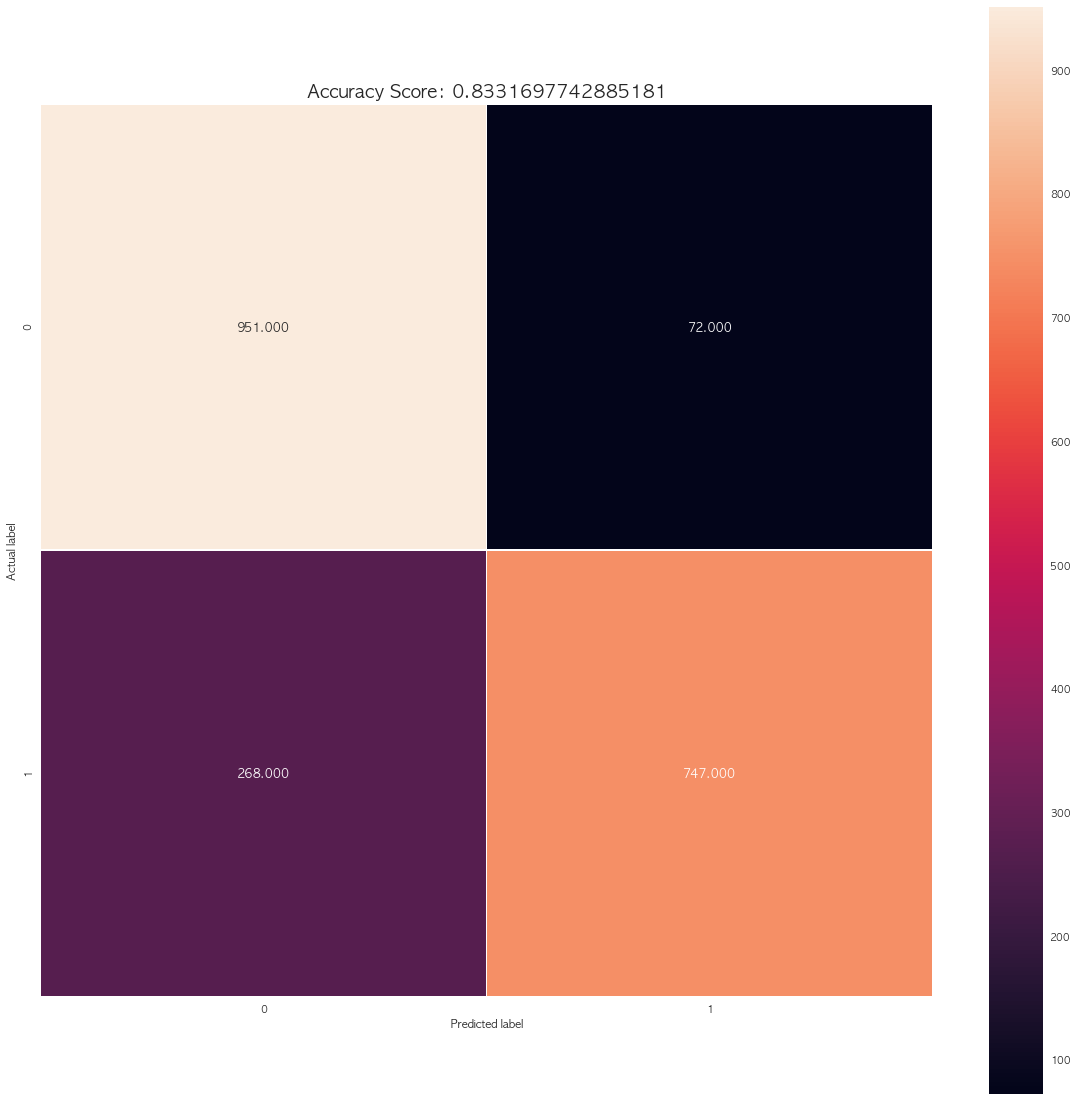

In [127]:
plt.figure(figsize=(20,20)) # chart size 
sns.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

In [128]:
from matplotlib import pyplot

## 꽤 높은 정확도를 가짐을 알 수 있음

### Auto ML

In [129]:
from pycaret.classification import *

In [139]:
feature_list = list(new_grid.drop(columns = ['음식점','행정동코드','행정동면적','ID','GRADE_전체','총인구','유소년인구','성폭력취약인구','건축물(30_34)','건축물(35)','대규모점포','파출소','자율방범대']).columns)

feature = new_grid[feature_list]

In [140]:
# 'voted' 컬럼이 예측 대상이므로 target 인자에 명시
# 'voted' column is the target variable
clf = setup(data = feature,
            train_size = 0.7,
            target = '범죄발생',
            use_gpu = False, 
            session_id = 123,
           fold_shuffle = True,
           remove_multicollinearity = True, multicollinearity_threshold = 0.6)

,Description,Value
0,session_id,123
1,Target,범죄발생
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(2038, 23)"
5,Missing Values,False
6,Numeric Features,22
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [141]:
best_5 = compare_models(sort = 'Accuracy', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8366,0.9003,0.7475,0.9089,0.8195,0.6729,0.6845,0.0340
gbc,Gradient Boosting Classifier,0.8303,0.9033,0.7630,0.8807,0.8171,0.6603,0.6669,0.2180
catboost,CatBoost Classifier,0.8303,0.9023,0.7616,0.8816,0.8166,0.6603,0.6671,1.4990
rf,Random Forest Classifier,0.8240,0.8947,0.7715,0.8631,0.8133,0.6478,0.6533,0.2810
et,Extra Trees Classifier,0.8219,0.8952,0.7870,0.8474,0.8144,0.6437,0.6475,0.2350
nb,Naive Bayes,0.8191,0.8849,0.6911,0.9274,0.7911,0.6376,0.6598,0.0300
ada,Ada Boost Classifier,0.8184,0.8890,0.7574,0.8631,0.8053,0.6365,0.6429,0.1860
ridge,Ridge Classifier,0.8170,0.0000,0.6855,0.9281,0.7882,0.6334,0.6563,0.0120
lda,Linear Discriminant Analysis,0.8170,0.8912,0.6855,0.9281,0.7882,0.6334,0.6563,0.0260
qda,Quadratic Discriminant Analysis,0.8163,0.8858,0.6954,0.9163,0.7894,0.6320,0.6520,0.0140


In [142]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8357,0.9021,0.7958,0.8626,0.8278,0.6711,0.6731
1,0.8351,0.8889,0.7394,0.9130,0.8171,0.6700,0.6823
2,0.8456,0.9041,0.7676,0.9083,0.8321,0.6911,0.6995
3,0.8491,0.9205,0.7817,0.9024,0.8377,0.6981,0.7044
4,0.8456,0.9089,0.7872,0.8880,0.8346,0.6908,0.6952
Mean,0.8422,0.9049,0.7743,0.8949,0.8299,0.6842,0.6909
SD,0.0057,0.0102,0.0197,0.0182,0.0071,0.0115,0.0115


In [143]:
rf = create_model('rf', cross_validation=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8112,0.8498,0.7465,0.8548,0.7970,0.6220,0.6270
1,0.8182,0.9309,0.8451,0.8000,0.8219,0.6365,0.6375
2,0.8252,0.8762,0.7042,0.9259,0.8000,0.6498,0.6690
3,0.7902,0.8790,0.7606,0.8060,0.7826,0.5802,0.5811
4,0.8182,0.8784,0.7606,0.8571,0.8060,0.6361,0.6401
5,0.8252,0.9122,0.7465,0.8833,0.8092,0.6500,0.6578
6,0.8451,0.9056,0.7746,0.9016,0.8333,0.6901,0.6971
7,0.8451,0.9261,0.8169,0.8657,0.8406,0.6901,0.6912
8,0.8592,0.8913,0.7887,0.9180,0.8485,0.7183,0.7255
9,0.8028,0.8975,0.7714,0.8182,0.7941,0.6052,0.6062


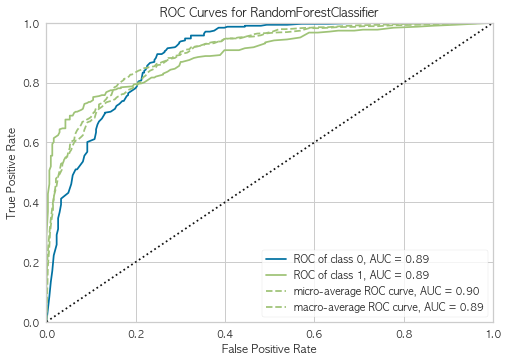

In [144]:
plot_model(rf)

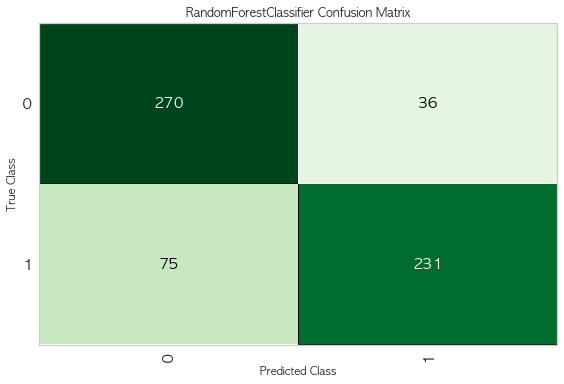

In [145]:
plot_model(rf, plot='confusion_matrix')

In [146]:
evaluate_model(rf)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


In [147]:
plt.rc('font', family="AppleGothic")


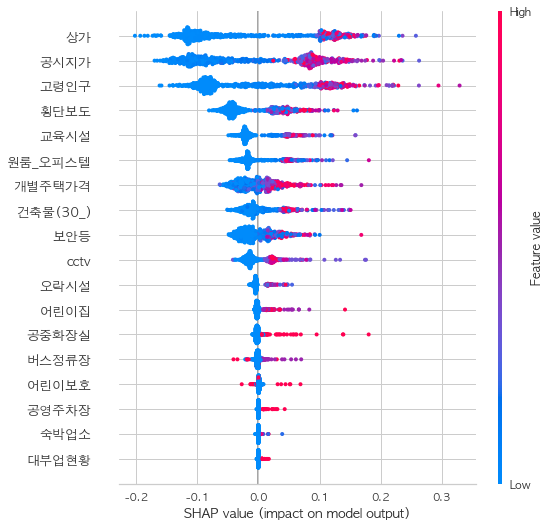

In [148]:
interpret_model(rf)

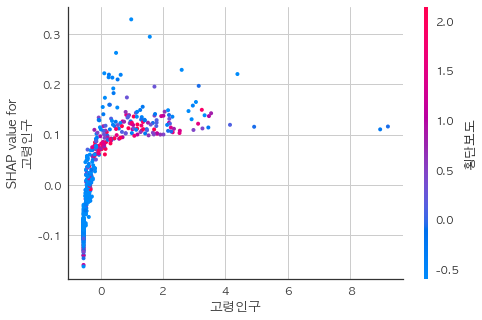

In [149]:
interpret_model(rf, plot='correlation')

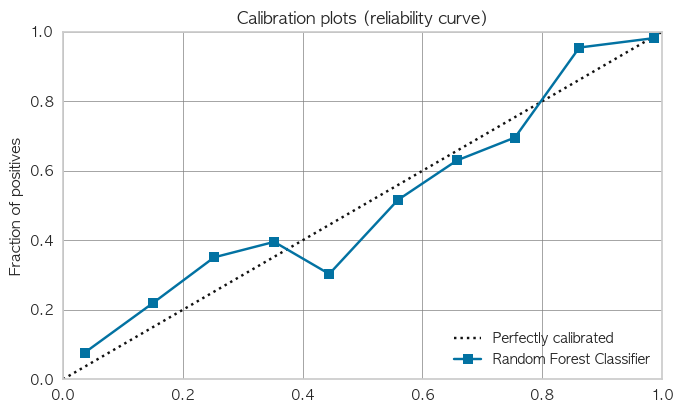

In [151]:
plot_model(rf, 'calibration')


In [150]:
#다중공선성확인
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
vif["features"] = feature.columns 
vif

,VIF Factor,features
0,1.894017,고령인구
1,1.175552,개별주택가격
2,2.597557,공시지가
3,2.004652,가로등
4,1.183506,공영주차장
5,1.119227,공중화장실
6,2.021835,교육시설
7,1.130061,대부업현황
8,1.915543,룸살롱
9,1.475829,버스정류장
